In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# GraphRAG on Google Cloud With Spanner


|Author(s) | [Tristan Li](https://github.com/codingphun)


## Overview


Spanner Graph now [integrates seamlessly with LangChain](https://cloud.google.com/python/docs/reference/langchain-google-spanner/latest#spanner-graph-store-usage), making it easier to build GraphRAG applications.

Instead of simply retrieving relevant text snippets based on keyword similarity, GraphRAG takes a more sophisticated, structured approach to Retrieval Augmented Generation. It involves creating a knowledge graph from the text, organizing it hierarchically, summarizing key concepts, and then using this structured information to enhance the accuracy and depth of responses.


### Objectives

In this tutorial, you will see a complete walkthrough of building a question-answering system using the GraphRAG method. You'll learn how to create a knowledge graph from scratch, store it efficiently in Spanner Graph, a functional FAQ system with Langchain agent.

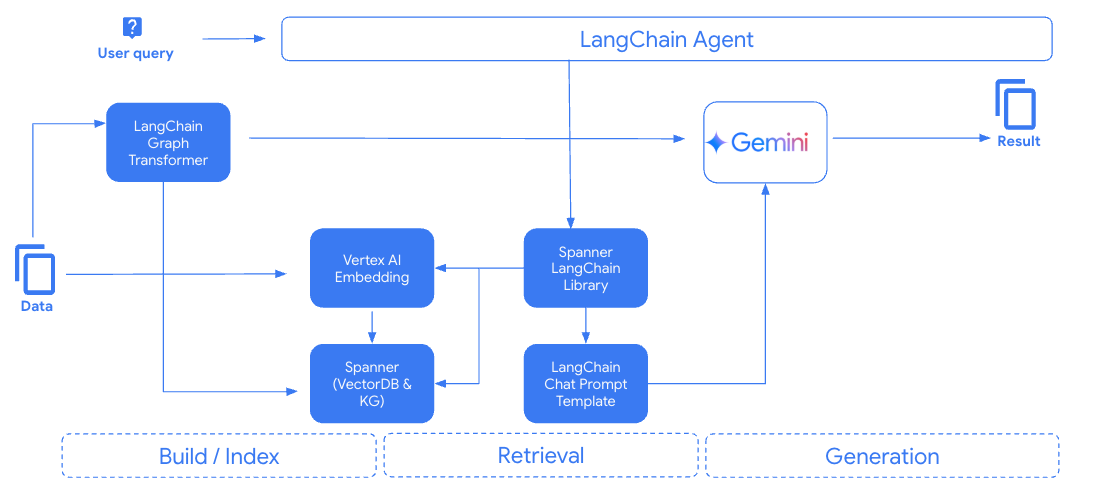

## Before you begin

1. In the Google Cloud console, on the project selector page, select or [create a Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects).
1. [Make sure that billing is enabled for your Google Cloud project](https://cloud.google.com/billing/docs/how-to/verify-billing-enabled#console).
1. [Make sure Cloud Spanner API is enabled](https://console.cloud.google.com/flows/enableapi?apiid=spanner.googleapis.com)

### Required roles

To get the permissions that you need to complete the tutorial, ask your administrator to grant you the [Owner](https://cloud.google.com/iam/docs/understanding-roles#owner) (`roles/owner`) IAM role on your project. For more information about granting roles, see [Manage access](https://cloud.google.com/iam/docs/granting-changing-revoking-access).


### Install Python Libraries

In [ ]:
!pip install --quiet json-repair==0.30.2 networkx==3.3 langchain-core==0.3.19 langchain-google-vertexai==2.0.7 langchain-experimental==0.3.3 langchain-community==0.3.7 langchain-text-splitters==0.3.2
!pip install --quiet google-cloud-resource-manager==1.13.1 pydantic==2.9.2
!pip install --quiet google-cloud-spanner==3.48.0
!pip install --quiet langchain-google-spanner==0.8.2

### Restart the Kernel

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Authenticating your notebook environment
* If you are using **Colab** to run this notebook, uncomment the cell below and continue.
* If you are using **Vertex AI Workbench**, check out the setup instructions [here](https://github.com/GoogleCloudPlatform/generative-ai/tree/main/setup-env).

In [ ]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth as google_auth
    google_auth.authenticate_user()
print(sys.version)
# If using local jupyter instance, uncomment and run:
# !gcloud auth login

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


## Initialize and Import

In [ ]:
GCP_PROJECT_ID = "" # @param {type:"string"}
REGION = "us-central1" # @param {type:"string"}
MODEL_NAME="gemini-2.0-flash-001" # @param {type:"string"}
EMBEDDING_MODEL_NAME="text-embedding-004" # @param {type:"string"}
TASK_TYPE = "SEMANTIC_SIMILARITY" # @param {type:"string"}
ANSWER_TASK_TYPE="RETRIEVAL_DOCUMENT" # @param {type:"string"}
SPANNER_INSTANCE_ID='graphrag-instance' # @param {type:"string"}
SPANNER_DATABASE_ID='graphrag' # @param {type:"string"}
SPANNER_GRAPH_NAME='wikigraph' # @param {type:"string"}

In [ ]:
# Set the project id
!gcloud config set project {GCP_PROJECT_ID} --quiet
%env GOOGLE_CLOUD_PROJECT={GCP_PROJECT_ID}

### Import Packages

In [ ]:
import os
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_vertexai import VertexAI
from langchain.chains import GraphQAChain
from langchain_core.documents import Document
from langchain_community.graphs.networkx_graph import NetworkxEntityGraph
import matplotlib.pyplot as plt

## Create Spanner Instance and Database

To prepare for future queries, we'll now store our newly created knowledge graph in a Google Cloud Spanner database. We'll also store the accompanying embeddings in Spanner's Vector Database to enable efficient semantic search.


In [ ]:
!gcloud config set project {GCP_PROJECT_ID}
!gcloud services enable spanner.googleapis.com
!gcloud spanner instances create {SPANNER_INSTANCE_ID} --config=regional-us-central1 --description="Graph RAG Instance" --nodes=1 --edition=ENTERPRISE

Updated property [core/project].


In [ ]:
# prompt: create a spanner database and table to store the graph with nodes and edges created in graph
def create_database(project_id, instance_id, database_id):
    """Creates a database and tables for sample data."""
    from google.cloud.spanner_admin_database_v1.types import spanner_database_admin
    from google.cloud import spanner
    spanner_client = spanner.Client(project_id)
    database_admin_api = spanner_client.database_admin_api

    request = spanner_database_admin.CreateDatabaseRequest(
        parent=database_admin_api.instance_path(spanner_client.project, instance_id),
        create_statement=f"CREATE DATABASE `{database_id}`",
        extra_statements= [
            """CREATE TABLE KgNode (
            DocId        INT64 NOT NULL,
            Name STRING(1024),
            DOC STRING(1024),
            DocEmbedding ARRAY<FLOAT64>
            ) PRIMARY KEY (DocId)"""])

    operation = database_admin_api.create_database(request=request)

    print("Waiting for operation to complete...")
    OPERATION_TIMEOUT_SECONDS=60
    database = operation.result(OPERATION_TIMEOUT_SECONDS)

    print(
        "Created database {} on instance {}".format(
            database.name,
            database_admin_api.instance_path(spanner_client.project, instance_id)
        )
    )

In [ ]:
from google.cloud import spanner
create_database(GCP_PROJECT_ID, SPANNER_INSTANCE_ID, SPANNER_DATABASE_ID)

Waiting for operation to complete...
Created database projects/data-cloud-demo2/instances/graphrag-instance/databases/graphrag on instance projects/data-cloud-demo2/instances/graphrag-instance


## Create a Knowledge Graph With LangChain and Gemini

These texts extracted from Wikipedia are about [Larry Page](https://en.wikipedia.org/wiki/Larry_Page), co-founder of Google. These texts will be used to create a knowledge graph about Larry Page as well as embedding vectors for semantic search.

In [ ]:
text = """Lawrence Edward Page (born March 26, 1973) is an American businessman and computer scientist best known for co-founding Google with Sergey Brin.
Lawrence Edward Page was chief executive officer of Google from 1997 until August 2001 when he stepped down in favor of Eric Schmidt,
and then again from April 2011 until July 2015 when he became CEO of its newly formed parent organization Alphabet Inc.
He held that post until December 4, 2019, when he and Brin stepped down from all executive positions and day-to-day roles within the company.
He remains an Alphabet board member, employee, and controlling shareholder. Lawrence Edward Page has an estimated net worth of $156 billion as of June 2024,
according to the Bloomberg Billionaires Index, and $145.2 billion according to Forbes, making him the fifth-richest person in the world.
He has also invested in flying car startups Kitty Hawk and Opener. Like his Google co-founder, Sergey Brin, Page attended Montessori schools until he entered high school.
They both cite the educational method of Maria Montessori as the major influence in how they designed Google's work systems.
Maria Montessori believed that the liberty of the child was of utmost importance. In some sense, I feel like music training led to the high-speed legacy of Google for me"""


We will use Gemini and Langchain LLMGraphTransformer to parse the texts and generate a knowledge graph.

Leveraging Gemini's capabilities, Langchain will use them to identify and extract key information from the text, such as people, countries, and their nationalities, to construct a comprehensive knowledge graph from the texts based on the nodes and relationships we define.

In [ ]:
documents = [Document(page_content=text)]

llm = VertexAI(model_name=MODEL_NAME,project=GCP_PROJECT_ID, location=REGION)

llm_transformer_filtered = LLMGraphTransformer(
    llm=llm,
    allowed_nodes=["Person", "Country", "Organization", "Asset"],
    allowed_relationships=["NATIONALITY", "LOCATED_IN", "WORKED_AT", "SPOUSE", "NET_WORTH", "INVESTMENT", "INFLUENCED_BY"]
)
graph_documents_filtered = llm_transformer_filtered.convert_to_graph_documents(documents)

## Store the Knowledge Graph in Spanner

Now that the Spanner database is created, we will store the Knowledge Graph in the Spanner Graph Store

In [ ]:
from langchain_google_spanner import SpannerGraphStore

graph_store = SpannerGraphStore(
    instance_id=SPANNER_INSTANCE_ID,
    database_id=SPANNER_DATABASE_ID,
    graph_name=SPANNER_GRAPH_NAME,
)

In [ ]:
# Uncomment the line below, if you want to cleanup from previous iterations.
# BeWARE - THIS COULD REMOVE DATA FROM YOUR DATABASE !!!
graph_store.cleanup()

for graph_document in graph_documents_filtered:
    graph_store.add_graph_documents([graph_document])

Waiting for DDL operations to complete...
Waiting for DDL operations to complete...
Insert nodes of type `Asset`...
Insert nodes of type `Country`...
Insert nodes of type `Organization`...
Insert nodes of type `Person`...
Insert edges of type `Person_WORKED_AT_Organization`...
Insert edges of type `Person_NATIONALITY_Country`...
Insert edges of type `Person_SPOUSE_Person`...
Insert edges of type `Person_NET_WORTH_Asset`...
Insert edges of type `Person_INVESTMENT_Organization`...
Insert edges of type `Person_INFLUENCED_BY_Person`...
Insert edges of type `Organization_LOCATED_IN_Country`...


## Build a QnA Agent

Let's build a QnA agent and ask quick questions

In [ ]:
from google.cloud import spanner
from langchain_google_spanner import SpannerGraphQAChain
from langchain_google_vertexai import ChatVertexAI

# Initialize llm object
llm = ChatVertexAI(model=MODEL_NAME, temperature=0)

# Initialize GraphQAChain
chain = SpannerGraphQAChain.from_llm(
    llm,
    graph=graph_store,
    allow_dangerous_requests=True,
    verbose=False,
    return_intermediate_steps=True,
)

In [ ]:
question = "What businesses does Lawrence Edward Page invest in?"  # @param {type:"string"}
response = chain.invoke("query=" + question)
response["result"]

'Lawrence Edward Page invests in Kitty Hawk and Opener.\n'

In [ ]:
%%spanner_graph --project {GCP_PROJECT_ID} --instance {SPANNER_INSTANCE_ID} --database {SPANNER_DATABASE_ID}

GRAPH wikigraph
MATCH p = (a)-[e]->(b)
RETURN TO_JSON(p) AS path_json
LIMIT 50

## Enhance Search Capability


Now if we rephrase the question with "Larry Page" instead of his legal name " Lawrence Edward Page", it would fail because it relies on exact keyword matching. Semantic search, using embeddings and vector search, overcomes this by understanding the meaning and relationships between words, thus recognizing both names refer to the same person! On the flip side, if we only use semantic search with vector similarity search, the results returned are not always accurate. See examples below on the challenges of either approach.

#### Generate the embeddings

In [ ]:
import json
import time
import pandas as pd
import vertexai
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from vertexai.generative_models import GenerationConfig, GenerativeModel, Content

# init the vertexai package
vertexai.init(project=GCP_PROJECT_ID, location=REGION)

def get_embedding(text, task_type, model):
  try:
    text_embedding_input = TextEmbeddingInput(task_type=task_type, text=text)
    embeddings = model.get_embeddings([text_embedding_input])
    return embeddings[0].values
  except:
    return []

embedding_model = TextEmbeddingModel.from_pretrained(EMBEDDING_MODEL_NAME)
text_model = GenerativeModel(MODEL_NAME)
documents = [Document(page_content=text)]

spanner_embedding_values=[]

from langchain.text_splitter import RecursiveCharacterTextSplitter
splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""]
)
splitted_text = splitter.split_documents(documents)
for chunk in splitted_text:
    chunk_content=chunk.page_content
    embedding = get_embedding(chunk_content, ANSWER_TASK_TYPE, embedding_model)
    user_prompt_content = "Find person's names but ignore any pronoun in the following sentence \n" + chunk_content
    response = text_model.generate_content(user_prompt_content, generation_config=GenerationConfig(temperature=0, response_mime_type = "application/json", response_schema = {"type":"OBJECT","properties":{"nodes":{"type":"STRING"}}}))
    response_content = json.loads(response.candidates[0].content.parts[0].text)["nodes"]
    print (embedding[:10], chunk_content[:10], response_content)
    spanner_embedding_values.append([embedding, chunk_content, response_content])


[0.04362960532307625, -0.015628624707460403, -0.03651438280940056, 0.07635214179754257, 0.025854211300611496, 0.016094792634248734, 0.032845646142959595, -0.025009311735630035, 0.033768218010663986, 0.0557292141020298] Lawrence E Lawrence Edward Page, Sergey Brin, Eric Schmidt
[0.05250556766986847, 0.0059433588758111, -0.053659338504076004, 0.0366397500038147, 0.027847468852996826, 0.006960400380194187, 0.0055380454286932945, -0.03739484027028084, 0.05096553638577461, 0.06589022278785706] He held th Brin, Lawrence Edward Page
[0.00012151900591561571, -0.04247371852397919, -0.06008194014430046, 0.08208870142698288, 0.022667380049824715, 0.015254673548042774, 0.03223690763115883, -0.016212889924645424, 0.02410755306482315, 0.021432554349303246] He has als Sergey Brin, Page, Maria Montessori


#### Knowledge graph search only - no result found

In [ ]:
question = "What businesses does Larry Page invest in?"  # @param {type:"string"}
response = chain.invoke("query=" + question)
response["result"]

"I don't know the answer."

#### Semantic search only - top similarity match is incorrect

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
QUESTION = "What businesses does Larry Page invest in?" # @param {type:"string"}

q_emb = get_embedding(QUESTION, ANSWER_TASK_TYPE, embedding_model)

for emb in spanner_embedding_values:
  print("chunk: {} \n similarity: {} \n".format(emb[1], cosine_similarity([q_emb], [emb[0]])))


chunk: Lawrence Edward Page (born March 26, 1973) is an American businessman and computer scientist best known for co-founding Google with Sergey Brin.
Lawrence Edward Page was chief executive officer of Google from 1997 until August 2001 when he stepped down in favor of Eric Schmidt,
and then again from April 2011 until July 2015 when he became CEO of its newly formed parent organization Alphabet Inc. 
 similarity: [[0.78622893]] 

chunk: He held that post until December 4, 2019, when he and Brin stepped down from all executive positions and day-to-day roles within the company.
He remains an Alphabet board member, employee, and controlling shareholder. Lawrence Edward Page has an estimated net worth of $156 billion as of June 2024,
according to the Bloomberg Billionaires Index, and $145.2 billion according to Forbes, making him the fifth-richest person in the world. 
 similarity: [[0.81792139]] 

chunk: He has also invested in flying car startups Kitty Hawk and Opener. Like his Google

#### Save the embeddings into Spanner

In [ ]:
from google.cloud import spanner
spanner_client = spanner.Client(GCP_PROJECT_ID)
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)
def insert_values(transaction):
    value1 = 0
    for sub_list in spanner_embedding_values:
        table_name = "KgNode"
        col_name1 = "docID"
        col_name2 = "Name"
        col_name3 = "Doc"
        col_name4 = "DocEmbedding"
        value1 += 1
        value2 = sub_list[2]
        value3 = sub_list[1]
        value4 = sub_list[0]
        #print(col_name1, col_name2, col_name3, col_name4, value1, value2, value3, value4[:10])
        row_ct1 = transaction.execute_update(
            f"INSERT INTO {table_name} ({col_name1}, {col_name2}, {col_name3}, {col_name4}) VALUES (@value1, @value2, @value3, @value4)",
            params={"value1": value1, "value2": value2, "value3": value3, "value4" : value4},
            param_types={"value1": spanner.param_types.INT64, "value2": spanner.param_types.STRING, "value3": spanner.param_types.STRING, "value4": spanner.param_types.Array(spanner.param_types.FLOAT64)})  # Adjust types if needed

        print("{} record(s) inserted.".format(row_ct1))
# print(insert_values)  # This just prints the function object, remove this line
database.run_in_transaction(insert_values)

1 record(s) inserted.
1 record(s) inserted.
1 record(s) inserted.


#### Combine both semantic search and graph search. Ask the question again - correct answer!



In [ ]:
import json
import time
import pandas as pd
import vertexai
from vertexai.language_models import TextEmbeddingInput, TextEmbeddingModel
from vertexai.generative_models import GenerationConfig, GenerativeModel, Content

QUESTION = "What businesses does Larry Page invest in?" # @param {type:"string"}
q_emb = get_embedding(QUESTION, TASK_TYPE, embedding_model)

spanner_client = spanner.Client(GCP_PROJECT_ID)
instance = spanner_client.instance(SPANNER_INSTANCE_ID)
database = instance.database(SPANNER_DATABASE_ID)
kgnodename=''
with database.snapshot() as snapshot:
    results = snapshot.execute_sql(
        """SELECT DocId, NAME, Doc FROM KgNode ORDER BY COSINE_DISTANCE(DocEmbedding, @q_emb) limit 1""",
        params={"q_emb": q_emb},
        param_types={"q_emb": spanner.param_types.Array(spanner.param_types.FLOAT64)}  # Adjust FLOAT64 if needed
    )
    for row in results:
        kgnodename=str(row[1])

text_model = GenerativeModel(MODEL_NAME)
user_prompt_content = "Find and replace entities such as person's name, place, nationality in the following sentence \n" + QUESTION + "with entities defined below \n" + kgnodename + "\n only replace matching person's name \n output the best replacement in a string"
#print (user_prompt_content)
response = text_model.generate_content(user_prompt_content, generation_config=GenerationConfig(temperature=0, response_mime_type = "application/json", response_schema = {"type":"OBJECT","properties":{"sentence":{"type":"STRING"}}}))
response_content = json.loads(response.candidates[0].content.parts[0].text)["sentence"]
print(response_content)
response = chain.invoke("query=" + response_content)
response["result"]

What businesses does Lawrence Edward Page invest in?


'Lawrence Edward Page invests in Kitty Hawk and Opener.\n'

## Clean Up

*   Delete the Spanner instance



In [ ]:
!gcloud spanner instances delete {SPANNER_INSTANCE_ID} --quiet

## What's next

* Dive deeper into [LangChain with Spanner](https://github.com/googleapis/langchain-google-spanner-python/tree/main).
* Learn more about [Spanner](https://cloud.google.com/spanner/docs/getting-started/python).
* Explore other [Spanner Graph Notebooks](https://github.com/cloudspannerecosystem/spanner-graph-notebook/blob/main/README.md).